# Libraries

In [11]:
import matplotlib.pyplot as plt
import yaml
import time
import re
import os
import numpy as np
import librosa
import models
import torch
import torch.nn as nn
import torch.optim as optimizer
import matplotlib.pyplot as plt

from scipy.stats import gamma
from data_bundler import DataBundler
from dataset_downloader import DatasetDownloader
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib.backends.backend_pdf import PdfPages

# Download Datasets

In [12]:
# dataset_downloader = DatasetDownloader()
# dataset_downloader.download_datasets("download_paths_2025.yaml")

# Hyper Parameters

In [13]:
def load_hyper_parameters():
    with open("hyper_parameters.yaml", 'r') as file:
        return yaml.safe_load(file)

In [14]:
hyper_parameters = load_hyper_parameters()

#> Acoustic Features
acoustic_features = hyper_parameters['acoustic_features']
number_of_mels = acoustic_features['number_of_mels']
number_of_frames_to_concatenate = acoustic_features['number_of_frames_to_concatenate']
frame_size_seconds = acoustic_features['frame_size_seconds']
frame_size_samples = acoustic_features['frame_size_samples']
hop_size_seconds = acoustic_features['hop_size_seconds']
hop_size_samples = acoustic_features['hop_size_samples']


#> Dataset Parameters
dataset_paremeters = hyper_parameters['dataset_parameters']
train_data_inclusion_string = dataset_paremeters['train_data_inclusion_string']
test_data_inclusion_string = dataset_paremeters['test_data_inclusion_string']
train_pct = dataset_paremeters['train_pct']
test_pct = dataset_paremeters['test_pct']


#> Training Parameters
training_parameters = hyper_parameters['training_parameters']
batch_size = training_parameters['batch_size']
epochs = training_parameters['epochs']
learning_rate = training_parameters['learning_rate']
shuffle = training_parameters['shuffle']

# Loading Datasets

In [15]:
data_bundler = DataBundler()
number_of_top_frequiences = 10

print("Training Data")
training_data, training_filenames, training_clip_lengths = data_bundler.load_dataset(train_data_inclusion_string, train_pct)
number_of_training_data = len(training_data)

Training Data


Processing audio files: 100%|██████████| 2500/2500 [00:28<00:00, 87.87file/s] 


Done loading!
Length of dataset: 160584



In [16]:
print("Testing Data")
testing_data, testing_filenames, testing_clip_lengths = data_bundler.load_dataset(test_data_inclusion_string, False, test_pct)
number_of_testing_data = len(testing_data)

Testing Data


Processing audio files: 100%|██████████| 20/20 [00:00<00:00, 52.85file/s]

Done loading!
Length of dataset: 1500



# Selecting Device

In [17]:
!nvidia-smi

Tue May 20 13:40:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              2W /   50W |       8MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

if torch.cuda.is_available():
    # Check if CUDA device 2 is available
    if torch.cuda.device_count() > 2:
        device = torch.device("cuda:2")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA available: False
Number of GPUs: 0
Current device: CPU
Device name: N/A
Using device: cpu


# Training

In [19]:
model = models.BaselineAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training_dataset = torch.tensor(training_data, dtype=torch.float32)
training_input_features = DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
training_data

array([[-24.88295 , -30.807602, -22.82386 , ..., -40.789303, -37.434544,
        -38.22042 ],
       [-26.901878, -22.385147, -26.33691 , ..., -41.611713, -37.264893,
        -38.00808 ],
       [-29.138992, -24.27024 , -23.422928, ..., -39.334087, -40.043262,
        -38.387604],
       ...,
       [-42.19499 , -40.15368 , -42.63411 , ..., -54.1224  , -54.57393 ,
        -56.459328],
       [-44.166702, -43.000572, -36.67653 , ..., -54.18947 , -59.25354 ,
        -55.475685],
       [-41.1195  , -48.64505 , -41.877705, ..., -54.283993, -55.891907,
        -53.319862]], shape=(160584, 640), dtype=float32)

In [20]:
training_losses = []

def train_model():
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for data in training_input_features:
            input = data.to(device)
            optimizer.zero_grad()

            output = model(input)
            loss = criterion(output, input)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(training_input_features)
        training_losses.append(avg_loss)

        elapsed_time = time.time() - start_time
        print(f"Epoch [{epoch + 1}/{epochs}] ({elapsed_time:.2f}s) | Loss: {avg_loss:.4f}")

    model.eval()

In [21]:
train_model()

Epoch [1/50] (7.12s) | Loss: 315.3603
Epoch [2/50] (13.61s) | Loss: 25.3342
Epoch [3/50] (19.38s) | Loss: 19.8558
Epoch [4/50] (25.67s) | Loss: 17.4540
Epoch [5/50] (31.25s) | Loss: 15.8383
Epoch [6/50] (36.71s) | Loss: 14.9614
Epoch [7/50] (42.28s) | Loss: 14.4453
Epoch [8/50] (47.65s) | Loss: 13.8881
Epoch [9/50] (53.17s) | Loss: 13.2848
Epoch [10/50] (58.64s) | Loss: 12.9636
Epoch [11/50] (64.09s) | Loss: 12.7632
Epoch [12/50] (69.47s) | Loss: 12.5421
Epoch [13/50] (74.91s) | Loss: 12.3006
Epoch [14/50] (80.53s) | Loss: 12.1133
Epoch [15/50] (85.91s) | Loss: 11.9265
Epoch [16/50] (91.47s) | Loss: 11.8088
Epoch [17/50] (96.81s) | Loss: 11.7130
Epoch [18/50] (102.19s) | Loss: 11.6294
Epoch [19/50] (107.53s) | Loss: 11.5390
Epoch [20/50] (112.89s) | Loss: 11.4797
Epoch [21/50] (118.40s) | Loss: 11.3981
Epoch [22/50] (123.77s) | Loss: 11.3384
Epoch [23/50] (129.10s) | Loss: 11.2938
Epoch [24/50] (134.46s) | Loss: 11.2581
Epoch [25/50] (139.83s) | Loss: 11.2061
Epoch [26/50] (145.49s) | 

# Evaluating

In [22]:
testing_dataset = torch.tensor(testing_data, dtype=torch.float32)
testing_input_features = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [23]:
testing_output_features = []
mse_list = []

def evaluate_model():
    model.eval()
    total_mse = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in testing_input_features:
            input = data.to(device)
            output = model(input)

            testing_output_features.append(output.cpu().numpy())  # Store the reconstruction for later use

            mse = mse_loss(output, input, reduction='sum').item()
            mse_list.append(mse)
            total_mse += mse
            total_samples += input.numel()
            
    average_mse = total_mse / total_samples
    print(f"Average MSE: {average_mse:.4f}")

In [24]:
evaluate_model()
testing_output_features = np.vstack(testing_output_features)

Average MSE: 9.5402


In [25]:
testing_data

array([[-33.2625  , -49.497955, -44.96184 , ..., -60.371964, -61.481422,
        -60.36638 ],
       [-46.045746, -49.700726, -47.118656, ..., -63.409843, -63.100327,
        -59.53357 ],
       [-46.809914, -49.993465, -46.706875, ..., -60.71884 , -63.007774,
        -61.490845],
       ...,
       [-44.440697, -36.673935, -39.832726, ..., -53.366875, -50.472885,
        -58.026863],
       [-52.454338, -44.277725, -42.644638, ..., -52.13967 , -51.69127 ,
        -52.27082 ],
       [-43.86483 , -42.208893, -46.01487 , ..., -56.075737, -53.912155,
        -55.90777 ]], shape=(1500, 640), dtype=float32)

In [26]:
testing_output_features

array([[-43.09645 , -43.862957, -43.75961 , ..., -61.273006, -61.354553,
        -61.069668],
       [-46.359203, -46.627884, -46.621964, ..., -61.206974, -61.097435,
        -60.915604],
       [-47.28069 , -47.791676, -47.667606, ..., -61.2962  , -61.745148,
        -61.3943  ],
       ...,
       [-43.169376, -43.32414 , -43.429924, ..., -54.669506, -54.565796,
        -54.81795 ],
       [-43.232388, -43.42279 , -43.53313 , ..., -54.475708, -54.24889 ,
        -54.54426 ],
       [-43.43084 , -44.039375, -43.90178 , ..., -55.64643 , -55.416527,
        -55.435   ]], shape=(1500, 640), dtype=float32)

In [27]:
np.mean((testing_data - testing_output_features)**2)

np.float32(9.540167)

## Reconstructions

In [28]:
original_clips = []

start_index = 0

for size in testing_clip_lengths:
    end_index = start_index + size
    original_clips.append(testing_data[start_index:end_index])
    start_index = end_index

In [29]:
original_clips[0]

array([[-33.2625  , -49.497955, -44.96184 , ..., -60.371964, -61.481422,
        -60.36638 ],
       [-46.045746, -49.700726, -47.118656, ..., -63.409843, -63.100327,
        -59.53357 ],
       [-46.809914, -49.993465, -46.706875, ..., -60.71884 , -63.007774,
        -61.490845],
       ...,
       [-44.01985 , -43.814533, -57.334946, ..., -60.340523, -63.088516,
        -64.73442 ],
       [-47.300957, -50.511234, -55.774643, ..., -58.158924, -63.140938,
        -58.84477 ],
       [-53.24107 , -52.650497, -44.11387 , ..., -59.892815, -59.811275,
        -61.057083]], shape=(75, 640), dtype=float32)

In [30]:
reconstructed_clips = []
start_index = 0

for size in testing_clip_lengths:
    end_index = start_index + size
    reconstructed_clips.append(testing_output_features[start_index:end_index])
    start_index = end_index

In [31]:
recon_err_per_clip = []
for i in range(len(reconstructed_clips)):
    item1 = reconstructed_clips[i].reshape(-1)
    item2 = original_clips[i].reshape(-1)
    
    recon_err_per_clip.append(np.mean((item1 - item2)**2))

In [32]:
# clip = original_clips[0]  # shape (65, 650)

# # Extract last 10 columns
# last_top_columns = clip[:, -number_of_top_frequiences:]  # shape (65, 10)

# # Convert each column to a single value (e.g., mean across rows)
# last_top_list = list(np.mean(last_top_columns, axis=0))  # length 10 list

# # Keep the first 640 columns
# clip_trimmed = clip[:, :-number_of_top_frequiences]  # shape (65, 640)

# print(clip_trimmed.shape)  # (65, 640)
# print(len(last_top_list))   # 10


In [33]:
from audio_converter import AudioConverter
audio_converter = AudioConverter()

audio_clip_index = 0

original_input = audio_converter.output_to_mel(original_clips[0])
original_input

array([[-33.2625  , -49.497955, -44.96184 , ..., -44.11387 , -51.420166,
        -42.448463],
       [-31.940437, -51.97004 , -47.462242, ..., -47.78095 , -51.867023,
        -42.891132],
       [-32.706467, -57.603756, -52.51308 , ..., -50.534157, -59.852596,
        -54.37844 ],
       ...,
       [-48.81201 , -45.787605, -44.72343 , ..., -46.329014, -46.30139 ,
        -41.734516],
       [-53.648655, -50.37383 , -49.258663, ..., -50.62107 , -50.301407,
        -44.435883],
       [-60.1786  , -58.12678 , -60.371964, ..., -59.892815, -59.811275,
        -61.057083]], shape=(128, 375), dtype=float32)

In [34]:
# clip = reconstructed_clips[0]  # shape (65, 650)

# # Extract last 10 columns
# last_10_columns = clip[:, -10:]  # shape (65, 10)

# # Convert each column to a single value (e.g., mean across rows)
# last_10_list = list(np.mean(last_10_columns, axis=0))  # length 10 list

# # Keep the first 640 columns
# clip_trimmed = clip[:, :-10]  # shape (65, 640)

# print(clip_trimmed.shape)  # (65, 640)
# print(len(last_10_list))   # 10


In [35]:
recreated_output = audio_converter.output_to_mel(reconstructed_clips[0])

error_mel = original_input - recreated_output

In [36]:
# from audio_converter import AudioConverter
# audio_converter = AudioConverter()

# audio_clip_index = 0

# original_input = audio_converter.output_to_mel(original_clips[audio_clip_index])
# recreated_output = audio_converter.output_to_mel(reconstructed_clips[audio_clip_index])

# error_mel = original_input - recreated_output

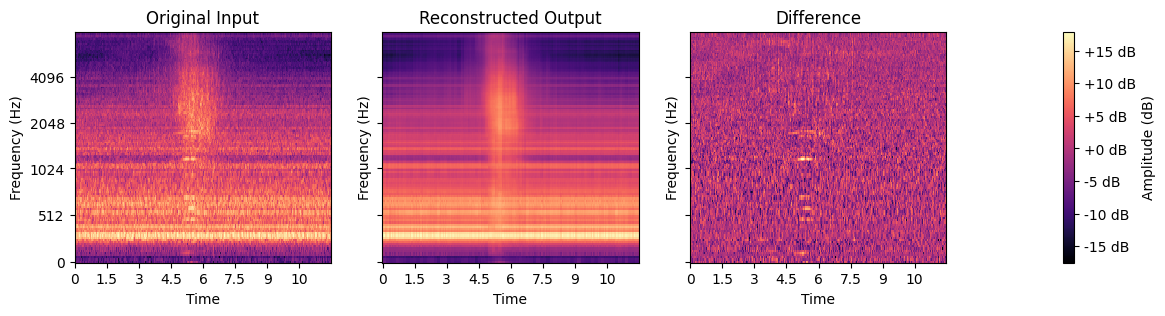

In [37]:
spectrogram_figures, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True)

# Plot each spectrogram
spectrograms = [original_input, recreated_output, error_mel]
titles = ['Original Input', 'Reconstructed Output', 'Difference']

for ax, spectrogram, title in zip(axes, spectrograms, titles):
    img = librosa.display.specshow(
        spectrogram,
        sr=16000,
        x_axis='time',
        y_axis='mel',
        cmap='magma',
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency (Hz)')

cbar = spectrogram_figures.colorbar(img, ax=axes, format='%+2.0f dB', location='right', pad=0.1)
cbar.set_label('Amplitude (dB)')

# Adjust spacing
# plt.tight_layout()
plt.show()

In [38]:
testing_dataset = torch.tensor(testing_data, dtype=torch.float32)
testing_input_features = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)
testing_data

array([[-33.2625  , -49.497955, -44.96184 , ..., -60.371964, -61.481422,
        -60.36638 ],
       [-46.045746, -49.700726, -47.118656, ..., -63.409843, -63.100327,
        -59.53357 ],
       [-46.809914, -49.993465, -46.706875, ..., -60.71884 , -63.007774,
        -61.490845],
       ...,
       [-44.440697, -36.673935, -39.832726, ..., -53.366875, -50.472885,
        -58.026863],
       [-52.454338, -44.277725, -42.644638, ..., -52.13967 , -51.69127 ,
        -52.27082 ],
       [-43.86483 , -42.208893, -46.01487 , ..., -56.075737, -53.912155,
        -55.90777 ]], shape=(1500, 640), dtype=float32)

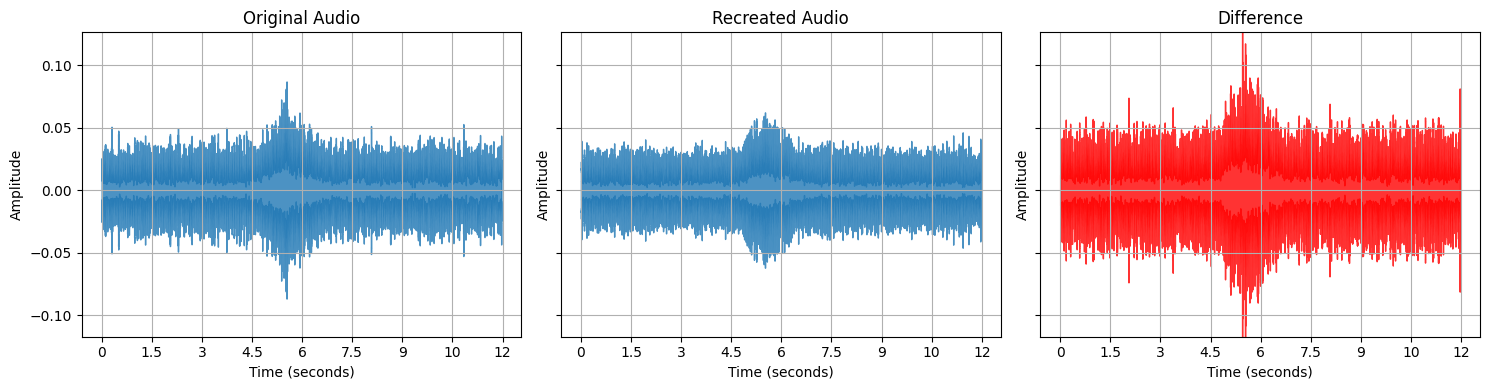

In [39]:
# Generate waveforms for original, recreated, and difference
original_wav = audio_converter.mel_to_wav(original_input)
recreated_wav = audio_converter.mel_to_wav(recreated_output)
difference_wav = original_wav - recreated_wav

# Find global y-axis limits
global_min = min(original_wav.min(), recreated_wav.min(), difference_wav.min())
global_max = max(original_wav.max(), recreated_wav.max(), difference_wav.max())

# Create subplots for waveforms
waveform_figures, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Data and titles for subplots
waveforms = [original_wav, recreated_wav, difference_wav]
titles = ['Original Audio', 'Recreated Audio', 'Difference']

# Plot each waveform
for ax, waveform, title in zip(axes, waveforms, titles):
    if title == 'Difference':  # Check if it's the difference plot
        librosa.display.waveshow(waveform, sr=16000, alpha=0.8, ax=ax, color='red')  # Set color to red
    else:
        librosa.display.waveshow(waveform, sr=16000, alpha=0.8, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_ylim(global_min, global_max)
    ax.grid()


# Adjust layout and display
plt.tight_layout()


In [40]:
import soundfile as sf

# Save the original audio as a .wav file
sf.write("reconstructions/original.wav", original_wav, 16000)

# Save the recreated audio as a .wav file
sf.write("reconstructions/recreated.wav", recreated_wav, 16000)

# Results

## Preparation for Visualization

In [41]:
epochs_range = range(1, epochs + 1)

In [42]:
status_list = []
pattern = r"_(normal|anomaly)_"

for line in testing_filenames:
    match = re.search(pattern, line)
    if match:
        status_list.append(match.group(1))

print(len(status_list))
status_list

20


['normal',
 'anomaly',
 'anomaly',
 'anomaly',
 'anomaly',
 'anomaly',
 'normal',
 'anomaly',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'anomaly',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'normal']

In [43]:
output_with_true_labels = list(zip(status_list, recon_err_per_clip))
print(output_with_true_labels)
sorted_output = sorted(output_with_true_labels, key=lambda x: x[1], reverse=True)
print(sorted_output)
labels, values = zip(*sorted_output)

print(labels)
print(values)

# over_threshold = 0
# for i in range(len(values)):
#     if values[i] > 16.02 and labels[i] == "anomaly":
#         print(values[i])
#         over_threshold += 1

# print(over_threshold)

[('normal', np.float32(9.7280855)), ('anomaly', np.float32(9.395735)), ('anomaly', np.float32(9.061787)), ('anomaly', np.float32(9.211206)), ('anomaly', np.float32(9.422456)), ('anomaly', np.float32(8.547812)), ('normal', np.float32(9.158402)), ('anomaly', np.float32(9.629316)), ('anomaly', np.float32(12.657654)), ('normal', np.float32(8.991907)), ('anomaly', np.float32(9.897976)), ('normal', np.float32(10.91649)), ('anomaly', np.float32(9.034494)), ('anomaly', np.float32(9.633714)), ('normal', np.float32(8.808935)), ('anomaly', np.float32(9.295345)), ('normal', np.float32(9.873506)), ('normal', np.float32(9.632403)), ('normal', np.float32(9.144881)), ('normal', np.float32(8.7612))]
[('anomaly', np.float32(12.657654)), ('normal', np.float32(10.91649)), ('anomaly', np.float32(9.897976)), ('normal', np.float32(9.873506)), ('normal', np.float32(9.7280855)), ('anomaly', np.float32(9.633714)), ('normal', np.float32(9.632403)), ('anomaly', np.float32(9.629316)), ('anomaly', np.float32(9.4224

In [44]:
colors = ['blue' if label == "normal" else 'red' for label in labels]
print(colors)

binary_labels = [1 if label == 'anomaly' else 0 for label in labels]
print(binary_labels)

['red', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'red']
[1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]


In [45]:
shape, loc, scale = gamma.fit(recon_err_per_clip)

x = np.linspace(0, max(values), 1000)
gamma_pdf = gamma.pdf(x, shape, loc=loc, scale=scale)

anomaly_threshold = gamma.ppf(0.9, shape, loc=loc, scale=scale)
# print(f"Anomaly threshold: {anomaly_threshold}")

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [47]:
anomaly_labels = (values > anomaly_threshold).astype(int)

cm = confusion_matrix(binary_labels, anomaly_labels.astype(int))

TN, FP, FN, TP = cm.ravel()

fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [48]:
roc_fpr, roc_tpr, thresholds = roc_curve(binary_labels, values)
auc_score = auc(roc_fpr, roc_tpr)
auc_score_2 = roc_auc_score(binary_labels, values)
print(f"AUC: {auc_score}")
print(f"AUC 2: {auc_score_2}")

AUC: 0.5454545454545454
AUC 2: 0.5454545454545454


# Visualizations

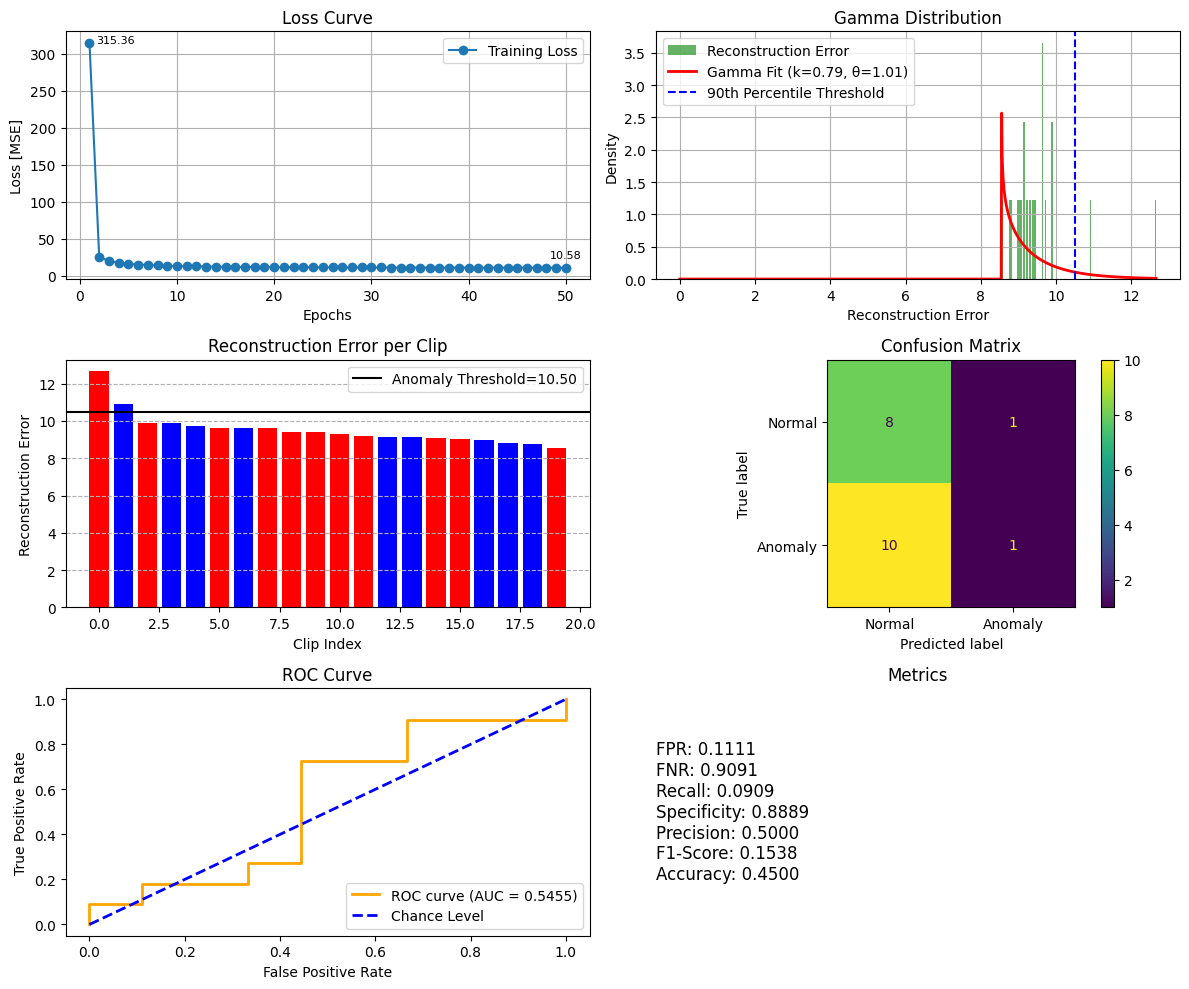

In [49]:
combined_results_figure, axes = plt.subplots(3,2, figsize=(12, 10))
axes = axes.flatten()


#> Loss Curve
axes[0].plot(epochs_range, training_losses, label='Training Loss', marker='o')
axes[0].annotate(
    f'{training_losses[0]:.2f}',
    (epochs_range[0], training_losses[0]),
    textcoords="offset points",
    xytext=(5,0),
    ha='left',
    fontsize=8
)
axes[0].annotate(
    f'{training_losses[-1]:.2f}',
    (epochs_range[-1], training_losses[-1]),
    textcoords="offset points",
    xytext=(0,7),
    ha='center',
    fontsize=8
)
axes[0].set_title('Loss Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss [MSE]')
axes[0].legend()
axes[0].grid()


#> Gamma Distribution
axes[1].hist(values, bins=100, density=True, color='green', alpha=0.6, label='Reconstruction Error')
axes[1].plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma Fit (k={shape:.2f}, θ={scale:.2f})')
axes[1].axvline(gamma.ppf(0.90, shape, loc=loc, scale=scale), color='b', linestyle='--', label='90th Percentile Threshold')
axes[1].set_title('Gamma Distribution')
axes[1].set_xlabel('Reconstruction Error')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True)


#> Reconstruction Errors
axes[2].axhline(y=anomaly_threshold, color='black', linestyle='-', label=f'Anomaly Threshold={anomaly_threshold:.2f}')
axes[2].bar(range(len(values)), values, color=colors)
axes[2].set_title('Reconstruction Error per Clip')
axes[2].set_xlabel('Clip Index')
axes[2].set_ylabel('Reconstruction Error')
axes[2].legend()
axes[2].grid(axis='y', linestyle='--')


#> Confusion Matrix
confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
confusion_matrix.plot(cmap='viridis', ax=axes[3])
axes[3].set_title("Confusion Matrix")


#> ROC Curve
axes[4].plot(roc_fpr, roc_tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
axes[4].plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Chance Level')
axes[4].set_title('ROC Curve')
axes[4].set_xlabel('False Positive Rate')
axes[4].set_ylabel('True Positive Rate')
axes[4].legend(loc='lower right')
axes[1].grid(True)


#> Metrics
metrics = f"FPR: {fpr:.4f}\nFNR: {fnr:.4f}\nRecall: {recall:.4f}\nSpecificity: {specificity:.4f}\nPrecision: {precision:.4f}\nF1-Score: {f1_score:.4f}\nAccuracy: {accuracy:.4f}"""
axes[5].axis('off')
axes[5].text(0, 0.5, metrics, fontsize=12, va='center', wrap=True)
axes[5].set_title("Metrics")


#> Show the plots
combined_results_figure.tight_layout()
plt.show()

# Saving Model and Results

In [50]:
folder_name = "saved_models"
os.makedirs(folder_name, exist_ok=True)

existing_files = [f for f in os.listdir(folder_name) if f.endswith('.pth')]
file_number = len(existing_files) + 1
pth_filename = os.path.join(folder_name, f"saved_model_{file_number}.pth")

torch.save(model.state_dict(), pth_filename)

In [51]:
#> Preparing folder and filename for PDF
folder_name = "training_results"
os.makedirs(folder_name, exist_ok=True)
existing_files = [f for f in os.listdir(folder_name) if f.endswith(".pdf")]
file_number = len(existing_files) + 1
pdf_filename = os.path.join(folder_name, f"training_results_{file_number}.pdf")


#> Model Structure
model_structure_string = str(model)
model_structure_figure, ms_axes = plt.subplots()
ms_axes.axis('off')
ms_axes.text(0, 0.5, model_structure_string, fontsize=7, va='center', wrap=True)
ms_axes.set_title("Model Structure")


#> Hyperparameters
hyper_parameters_string = yaml.dump(hyper_parameters, default_flow_style=False)
hyper_parameters_figure, hpf_axes = plt.subplots()
hpf_axes.axis('off')
hpf_axes.text(0.5, 0.5, hyper_parameters_string, fontsize=12, va='center', ha='center', wrap=True)
hpf_axes.set_title("Hyperparameters")


#> Save all figures to a single PDF
with PdfPages(pdf_filename) as pdf:
    pdf.savefig(combined_results_figure)
    pdf.savefig(spectrogram_figures)
    pdf.savefig(waveform_figures)
    pdf.savefig(hyper_parameters_figure)
    pdf.savefig(model_structure_figure)
    plt.close('all')